In [6]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=ToTensor()
)

len(train_data), len(test_data)

(60000, 10000)

In [7]:
class_name = test_data.classes
class_name

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
image, label = test_data[42]
image.shape

torch.Size([1, 28, 28])

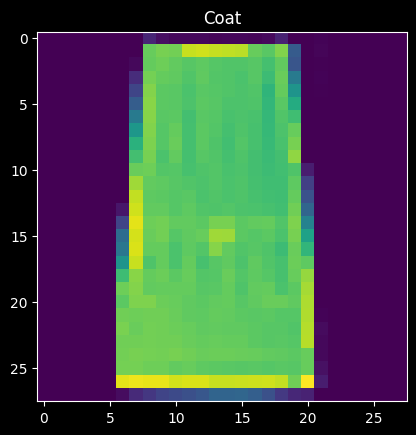

In [27]:
import matplotlib.pyplot as plt

plt.imshow(image.squeeze())
plt.title(class_name[label])
plt.show()

In [28]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=32,
    shuffle=False,
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f6dfe9f4050>,
 <torch.utils.data.dataloader.DataLoader at 0x7f6e004e88a0>)

In [29]:
image.shape[0]

1

In [30]:
from torch import nn


class FashionMNISTCNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.classifier(x)
        return x


model = FashionMNISTCNN(input_shape=image.shape[0], hidden_units=30, output_shape=10)
model

FashionMNISTCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1470, out_features=10, bias=True)
  )
)

In [31]:
import torch

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def acc_fn(gts, preds):
    equals = torch.eq(gts, preds).sum().item()
    acc = equals / len(gts) * 100.0
    return acc

In [32]:
def train_steps(
        dataloader: DataLoader,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        loss_fn,
        acc_fn,
        device=torch.device
):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (img, gts) in enumerate(dataloader):
        img, gts = img.to(device), gts.to(device)
        label_pred = model(img)

        loss = loss_fn(label_pred, gts)
        train_loss += loss.item()
        train_acc += acc_fn(gts, label_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")



In [33]:
def test_steps(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn,
        acc_fn,
        device=torch.device
):
    model.to(device)
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (img, gts) in enumerate(dataloader):
            img, gts = img.to(device), gts.to(device)
            label_pred = model(img)
            test_loss += loss_fn(label_pred, gts)
            test_acc += acc_fn(gts, label_pred.argmax(dim=1))

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [34]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 3

for epoch in range(epochs):
    train_steps(train_dataloader, model, optimizer, loss_fn, acc_fn, device=device)
    test_steps(test_dataloader, model, loss_fn, acc_fn, device=device)

Train loss: 0.43287 | Train accuracy: 84.31%
Test loss: 0.32998 | Test accuracy: 88.41%

Train loss: 0.27728 | Train accuracy: 89.97%
Test loss: 0.26330 | Test accuracy: 90.48%

Train loss: 0.23432 | Train accuracy: 91.50%
Test loss: 0.25233 | Test accuracy: 90.91%



In [35]:
def eval_model(
        model: nn.Module,
        dataloader: DataLoader,
        loss_fn,
        acc_fn,
        device: torch.device
):
    loss, acc = 0, 0
    with torch.inference_mode():
        for img, gts in dataloader:
            img, gts = img.to(device), gts.to(device)
            pred = model(img)
            loss += loss_fn(pred, gts)
            acc += acc_fn(gts, pred.argmax(dim=1))

        loss /= len(dataloader)
        acc /= len(dataloader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}


In [36]:
model_res = eval_model(model=model, dataloader=test_dataloader, loss_fn=loss_fn, acc_fn=acc_fn, device=device)
model_res

{'model_name': 'FashionMNISTCNN',
 'model_loss': 0.25232812762260437,
 'model_acc': 90.91453674121406}

In [37]:
def make_predictions_probs(
        model: nn.Module,
        data: list,
        device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    predictions = []
    with torch.inference_mode():
        model.to(device)
        for img in data:
            img = torch.unsqueeze(img, dim=0).to(device)
            logits = model(img)
            probs = torch.softmax(logits.squeeze(), dim=0)
            predictions.append(probs.cpu())

    return torch.stack(predictions)

In [38]:
import random

random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), 16):
    test_samples.append(sample)
    test_labels.append(label)

print(
    f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_name[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [39]:
prediction_probs = make_predictions_probs(
    model=model,
    data=test_samples
)
prediction_probs[:2], prediction_probs.shape

(tensor([[1.5105e-09, 1.6085e-11, 6.0884e-10, 7.6061e-12, 9.4858e-12, 9.9999e-01,
          1.1381e-08, 3.3992e-08, 6.8501e-07, 5.4541e-06],
         [1.0787e-02, 9.7260e-01, 1.0733e-04, 4.3656e-03, 7.2813e-03, 1.1091e-05,
          4.8160e-03, 3.9644e-06, 1.6209e-05, 9.6191e-06]]),
 torch.Size([16, 10]))

In [40]:
predictions = prediction_probs.argmax(dim=1)
predictions

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1, 9, 7, 2, 0, 1, 0, 3])

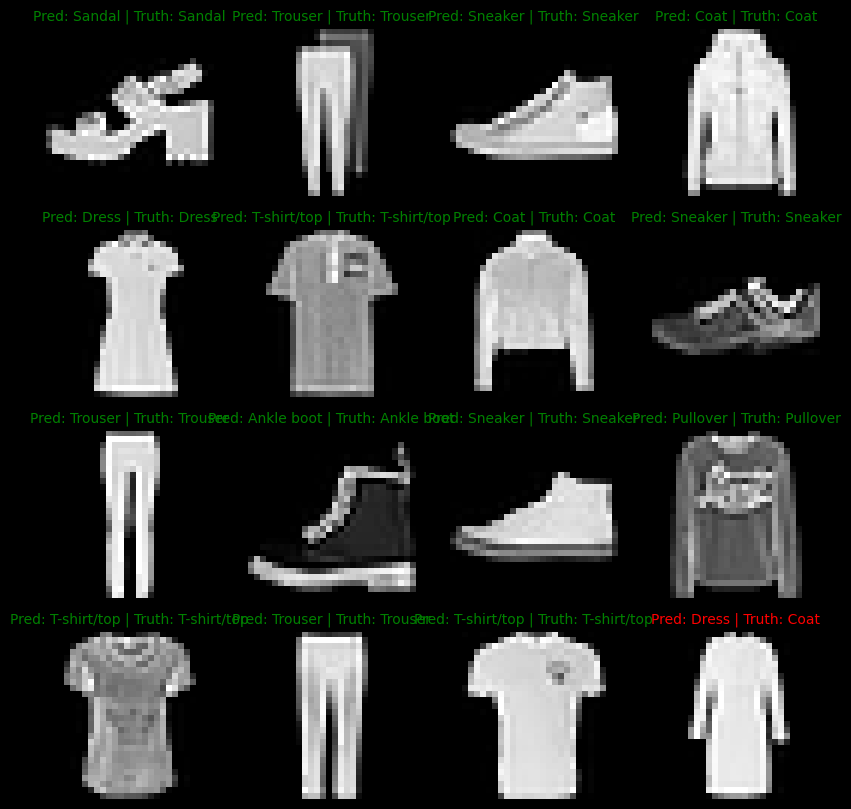

In [41]:
plt.figure(figsize=(10, 10))
nrows = 4
ncols = 4
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_label = class_name[predictions[i]]
    truth_label = class_name[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
    plt.axis(False)

In [42]:
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictions = []
with torch.inference_mode():
    for img, gst in tqdm(test_dataloader, desc="Making predictions"):
        img, gst = img.to(device), gst.to(device)
        logits = model(img)
        prediction = torch.softmax(logits, dim=1).argmax(dim=1)
        predictions.append(prediction.cpu())

predictions_tensor = torch.cat(predictions)
predictions_tensor.shape, predictions_tensor

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

(torch.Size([10000]), tensor([9, 2, 1,  ..., 8, 1, 5]))

In [43]:
try:
    import torchmetrics, mlxtend

    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend

    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.24.0


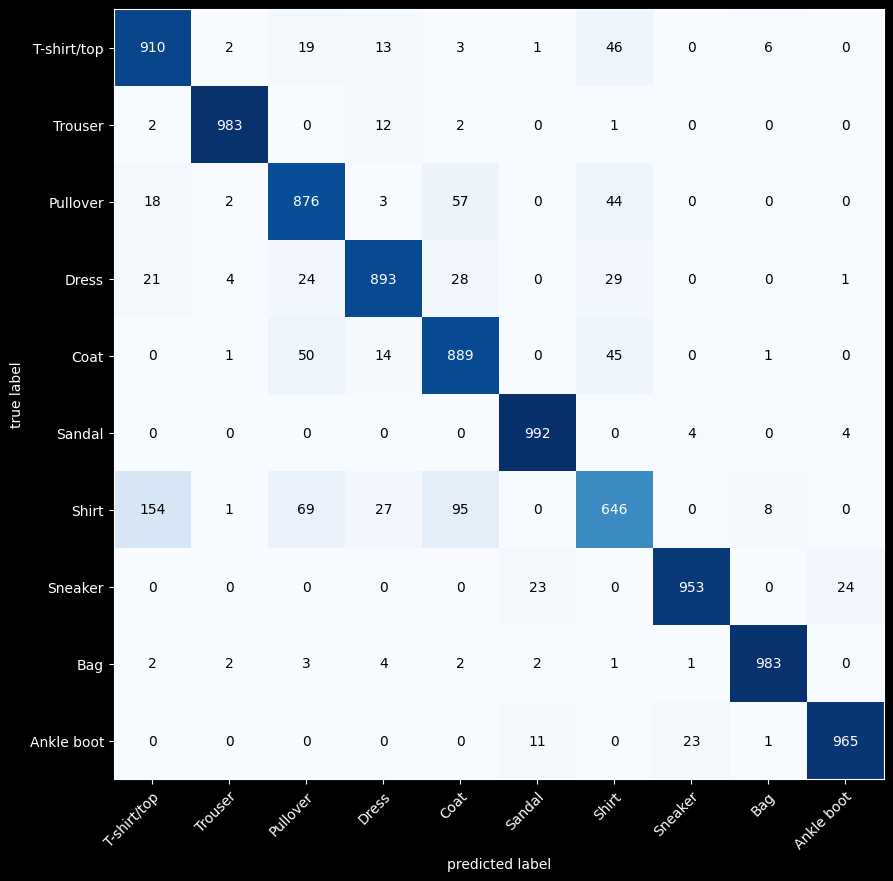

In [44]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_name), task='multiclass')
confmat_tensor = confmat(preds=predictions_tensor,
                         target=test_dataloader.dataset.targets)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_name,
    figsize=(10, 10),
)

* practise

In [44]:
import kagglehub

dataset_path = kagglehub.dataset_download(
    handle="alessiocorrado99/animals10",
)

100%|██████████| 586M/586M [01:10<00:00, 8.74MB/s] 

Extracting files...


In [45]:
translate = {
    "dog": "cane", "horse": "cavallo", "elephant": "elefante", "butterfly": "farfalla", "chicken": "gallina",
    "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo", "sheep": "pecora"
}
translate

{'dog': 'cane',
 'horse': 'cavallo',
 'elephant': 'elefante',
 'butterfly': 'farfalla',
 'chicken': 'gallina',
 'cat': 'gatto',
 'cow': 'mucca',
 'spider': 'ragno',
 'squirrel': 'scoiattolo',
 'sheep': 'pecora'}

In [47]:
import subprocess

source_dir = "/home/primel/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img/"

subprocess.call("mkdir ~/PycharmProjects/pytorch/data/animals", shell=True)

for key, value in translate.items():
    command = f"""
    mkdir ~/PycharmProjects/pytorch/data/animals/{key}
    mv {source_dir}{value}/* ./data/animals/{key}
    """
    subprocess.call(command, shell=True)

tensor([[[[0.9059, 0.9059, 0.9020,  ..., 0.9412, 0.9451, 0.9451],
          [0.9059, 0.9059, 0.9020,  ..., 0.9412, 0.9412, 0.9451],
          [0.9020, 0.9020, 0.8980,  ..., 0.9373, 0.9412, 0.9412],
          ...,
          [0.3373, 0.3333, 0.3294,  ..., 0.9529, 0.9529, 0.9529],
          [0.3333, 0.3333, 0.3294,  ..., 0.9529, 0.9529, 0.9529],
          [0.3647, 0.3373, 0.3176,  ..., 0.9569, 0.9569, 0.9529]],

         [[0.9059, 0.9059, 0.9020,  ..., 0.9137, 0.9176, 0.9176],
          [0.9059, 0.9059, 0.9020,  ..., 0.9137, 0.9137, 0.9176],
          [0.9020, 0.9020, 0.8980,  ..., 0.9098, 0.9137, 0.9137],
          ...,
          [0.3451, 0.3412, 0.3373,  ..., 0.9333, 0.9333, 0.9333],
          [0.3412, 0.3412, 0.3373,  ..., 0.9333, 0.9333, 0.9333],
          [0.3725, 0.3451, 0.3255,  ..., 0.9373, 0.9373, 0.9333]],

         [[0.8667, 0.8667, 0.8627,  ..., 0.8902, 0.8941, 0.8941],
          [0.8667, 0.8667, 0.8627,  ..., 0.8902, 0.8902, 0.8941],
          [0.8627, 0.8627, 0.8588,  ..., 0

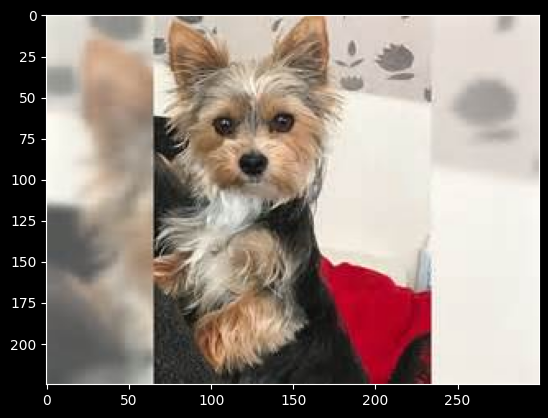

In [51]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor

path = "/home/primel/PycharmProjects/pytorch/data/animals/dog/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg"
img = Image.open(path).convert("RGB")
a = ToTensor()(img).unsqueeze(0)

plt.imshow(img, cmap="gray")
a

In [27]:
class_names = list(translate.keys())
class_names

['dog',
 'cavallo',
 'elephant',
 'butterfly',
 'chicken',
 'cat',
 'cow',
 'spider',
 'squirrel']